In [212]:
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cross_validation import train_test_split
from pretrainedmodels.models import bninception

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time
from queue import Queue
import random
import math

import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import copy
from scipy import stats
import scipy.signal as signal
from imgaug import augmenters as iaa

random_seed = 4050
config_batch_size = 16
class_n = (9 + 10 + 26)
output_n = 9
num_epochs = 100
mu ,sigma = 0, 5
feature_extract = True
use_pretrained=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

char_to_index = {"深":0, "秦":1, "京":2, "海":3, "成":4, "南":5, "杭":6, "苏":7, "松":8}
print(char_to_index)

{'深': 0, '秦': 1, '京': 2, '海': 3, '成': 4, '南': 5, '杭': 6, '苏': 7, '松': 8}


In [2]:
label_file = "./data/train-data-label.txt"
image_file = "./data/train-data"
data_list = []
with open(label_file, 'r') as file_to_read:
    while True:
        lines = file_to_read.readline().strip() # 整行读取数据
        if not lines:
            break
        lines = lines.split(",  ")
        image_path = os.path.join(image_file, lines[1])
        label = [];
        label.append(char_to_index[lines[0][0]])
        for i in range(1, len(lines[0])):
            if '0' <= lines[0][i] and lines[0][i] <= '9':
                label.append(9 + ord(lines[0][i]) - ord('0'))
            else:
                label.append(9 + 10 + ord(lines[0][i]) - ord('A'))
        data_list.append({"image_path": image_path, "label":label})

{'image_path': './data/train-data/51f534ee89473f1f.jpg', 'label': [5, 19, 44, 26, 42, 29, 43, 18, 12]}
(70, 356, 3)


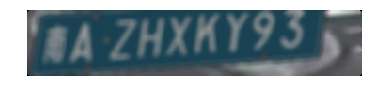

In [277]:
data_index = 3010#713
print(data_list[data_index])
img = Image.open(data_list[data_index]["image_path"])
img = np.array(img)
for i in range(len(img[0,0])):
    img[:,:,i] = signal.medfilt2d(img[:,:,i], kernel_size=5)
print(img.shape)
h, w, _ = img.shape
plt.figure("love")
plt.imshow(img, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

/home/lbyg/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """


max_count =  8170.0


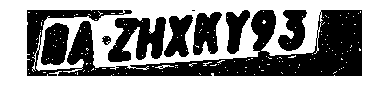

In [278]:
diff_threshold = 80
def diff(val_x, val_y):
    diff_sum = 0
    for i in range(len(val_x)):
        diff_sum += (val_x[i] - val_y[i]) * (val_x[i] - val_y[i])
    return diff_sum

count = np.zeros((h, w))
max_count = 0
max_i, max_j = 0, 0
for i in range(0, h, h // 10):
    base_x = (random.randint(0, h // 20) + i) % h
    for j in range(0, w, w // 10):
        base_y = (random.randint(0, w // 20) + j) % w
        for x in range(h):
            for y in range(w):
                if diff(img[base_x, base_y], img[x, y]) < diff_threshold:
                    count[base_x, base_y] += 1
        if max_count < count[base_x, base_y]:
            max_count = count[base_x, base_y]
            max_i = base_x
            max_j = base_y
flag = np.zeros((h, w))
for i in range(h):
    for j in range(w):
        if diff(img[i, j], img[max_i, max_j]) < diff_threshold:
            flag[i, j] = 255
print("max_count = ", max_count)
plt.figure("love")
plt.imshow(flag, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
            

In [259]:
def add_point_to_img(img_with_point, x_add_y_min, point_width):
    _, i, j = x_add_y_min
    print(x_add_y_min)
    for x in range(i - point_width, i + point_width + 1):
        for y in range(j - point_width, j + point_width + 1):
            img_with_point[x, y] = [255, 0, 0]

[34, 11, 23]
[344, 41, 303]
[-306, 2, 308]
[48, 61, 13]


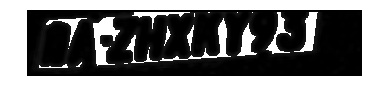

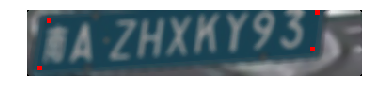

In [279]:
point_width = 2
img_with_point = img.copy()
flag_count = np.zeros((h, w))
for i in range(point_width, h - point_width):
    for j in range(point_width, w - point_width):
        for x in range(i - point_width, i + point_width + 1):
            for y in range(j - point_width, j + point_width + 1):
                if flag[x, y] == 255:
                    flag_count[i, j] += 1
        if flag_count[i, j] > (1 + point_width * 2) * (1 + point_width * 2) - 1:
            flag_count[i, j] = 255
            
x_add_y_min = [1e6, 0, 0]
x_add_y_max = [-1e6, 0, 0]
x_sub_y_min = [1e6, 0, 0]
x_sub_y_max = [-1e6, 0, 0]
for x in range(h):
    for y in range(w):
        if flag_count[x, y] == 255:
            x_add_y = x + y
            x_sub_y = x - y
            if x_add_y < x_add_y_min[0]:
                x_add_y_min = [x_add_y, x, y]
            if x_add_y > x_add_y_max[0]:
                x_add_y_max = [x_add_y, x, y]
            if x_sub_y < x_sub_y_min[0]:
                x_sub_y_min = [x_sub_y, x, y]
            if x_sub_y > x_sub_y_max[0]:
                x_sub_y_max = [x_sub_y, x, y]
add_point_to_img(img_with_point, x_add_y_min, point_width)
add_point_to_img(img_with_point, x_add_y_max, point_width)
add_point_to_img(img_with_point, x_sub_y_min, point_width)
add_point_to_img(img_with_point, x_sub_y_max, point_width)

plt.figure("love")
plt.imshow(flag_count, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
plt.figure("love")
plt.imshow(img_with_point, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [183]:
def reverse_write_and_black(flag):
    res = np.array(flag)
    h, w = res.shape
    for i in range(h):
        for j in range(w):
            if res[i,j] == 255:
                res[i,j] = 0
            else:
                res[i,j] = 255
    return res

In [199]:
def get_pts(end_point, box_point):
    res_index = []
    left_diff = diff(end_point[0], end_point[1])
    right_diff = diff(end_point[2], end_point[3])
    if left_diff > right_diff:
        res_index.extend([0, 1])
        if end_point[2, 1] - box_point[2, 1] > box_point[3, 1] - end_point[3, 1]:
            res_index.extend([2])
        else:
            res_index.extend([3])
    else:
        res_index.extend([2, 3])
        if end_point[0, 1] - box_point[0, 1] > box_point[1, 1] - end_point[1, 1]:
            res_index.extend([0])
        else:
            res_index.extend([1])
    return np.float32(end_point[res_index]), np.float32(box_point[res_index])

[[ 23.  11.]
 [ 13.  61.]
 [303.  41.]]
[[  0.   0.]
 [  0.  69.]
 [355.  69.]]


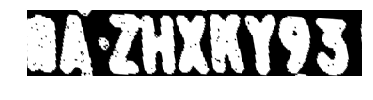

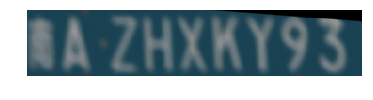

In [280]:
# 左上，左下，右上，右下
end_point = np.array([[x_add_y_min[2], x_add_y_min[1]], [x_sub_y_max[2], x_sub_y_max[1]], [x_sub_y_min[2], x_sub_y_min[1]], [x_add_y_max[2], x_add_y_max[1]]])
box_point = np.array([[0, 0], [0, h - 1], [w - 1, 0], [w - 1, h - 1]])

pts1, pts2 = get_pts(end_point, box_point)
print(pts1)
print(pts2)
#pts1 = np.float32([[x_add_y_min[2], x_add_y_min[1]], [x_sub_y_min[2], x_sub_y_min[1]], [x_sub_y_max[2], x_sub_y_max[1]]])
#pts2 = np.float32([[0, 0], [w - 1, 0], [0, h - 1]])
#print(pts1)
#print(pts2)
 
M = cv2.getAffineTransform(pts1, pts2)
flag_dst = cv2.warpAffine(reverse_write_and_black(flag), M, (w, h))
img_dst = cv2.warpAffine(img, M, (w, h))
plt.figure("love")
plt.imshow(flag_dst, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
plt.figure("love")
plt.imshow(img_dst, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

[32, 51, 51, 53, 51, 52, 52, 54, 52, 51, 52, 52, 51, 53, 50, 49, 49, 55, 56, 52, 54, 56, 57, 57, 53, 52, 52, 49, 49, 31, 3, 0, 0, 0, 0, 2, 11, 17, 22, 31, 41, 48, 54, 54, 54, 59, 60, 58, 54, 53, 49, 51, 51, 51, 50, 49, 42, 40, 44, 44, 35, 35, 35, 33, 30, 21, 18, 9, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 8, 10, 8, 5, 1, 1, 3, 0, 0, 12, 20, 24, 28, 33, 34, 32, 33, 41, 42, 46, 48, 52, 57, 60, 59, 58, 53, 47, 47, 43, 44, 40, 38, 37, 33, 30, 23, 21, 16, 8, 7, 7, 7, 10, 35, 48, 57, 58, 60, 61, 61, 59, 56, 54, 52, 46, 33, 20, 14, 12, 14, 14, 15, 25, 39, 49, 57, 59, 60, 60, 60, 60, 59, 60, 55, 49, 28, 6, 0, 0, 5, 9, 12, 21, 27, 33, 41, 45, 49, 57, 57, 53, 53, 49, 45, 44, 45, 47, 48, 47, 50, 54, 57, 58, 54, 44, 41, 35, 26, 14, 11, 7, 3, 2, 0, 0, 6, 26, 45, 56, 55, 57, 52, 50, 49, 48, 54, 57, 55, 53, 44, 35, 30, 33, 36, 40, 47, 47, 53, 57, 57, 55, 49, 43, 37, 32, 25, 20, 13, 10, 7, 1, 0, 2, 8, 7, 10, 11, 17, 17, 19, 21, 26, 30, 41, 53, 51, 51, 53, 53, 54, 55, 58, 59, 60, 61, 59, 45, 25, 22, 19, 14, 11

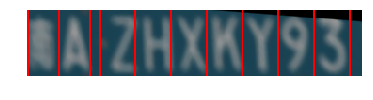

In [281]:
thickness = 2
flag_dst_threshold = 10
def draw_a_line(img_dst_segment, pos, thickness):
    h, w, _ = img_dst_segment.shape
    for x in range(h):
        for y in range(pos, min(pos + thickness, w)):
            img_dst_segment[x, y, :] = np.array([255, 0, 0])

img_dst_segment = img_dst.copy()
flag_dst_count = [0] * w
for x in range(h):
    for y in range(w):
        if flag_dst[x, y] == 255:
            flag_dst_count[y] += 1
print(flag_dst_count)
point_pos = w * 2 // 9

l, r = 0, point_pos
while l < w - 1 and flag_dst_count[l] < flag_dst_threshold:
    l += 1
while r > 0 and  flag_dst_count[r] < flag_dst_threshold:
    r -= 1
draw_a_line(img_dst_segment, l, thickness)
draw_a_line(img_dst_segment, r, thickness)
draw_a_line(img_dst_segment, (l+r) // 2, thickness)

l, r = point_pos, w - 1
while l < w - 1 and flag_dst_count[l] < flag_dst_threshold:
    l += 1
while r > 0 and  flag_dst_count[r] < flag_dst_threshold:
    r -= 1
count = 0
for i in range(l, r + 1):
    if flag_dst_count[i] < flag_dst_threshold:
        count += 1
count //= 12
print(count)
l = max(0, l - count)
r = min(w - 1, r + count)
draw_a_line(img_dst_segment, l, thickness)
draw_a_line(img_dst_segment, r, thickness)
for i in range(1, 7):
    pos = l + (r - l) * i // 7
    draw_a_line(img_dst_segment, pos, thickness)

plt.figure("love")
plt.imshow(img_dst_segment, cmap='gray') # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()